### Estimating uncertainty in a BNN using Laplace Approximation (classification task)

In [1]:
import os
path = os.getcwd()
if path.split(sep="\\")[-1]!='InternshipMatakos':
    os.chdir("..")

from src.inference.laplace import laplace_model
from src import evaluate
import src.utils
from src.utils import data_loaders
from src.utils.domain_split import hyperplane_split
from src.train_test import fit_class
from src.train_test import test_class
from src.model import MLP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from laplace import Laplace, marglik_training
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Diabetes dataset
df = pd.read_csv("data/classification/diabetes.csv", header=None)

D = df.values
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1)
df[dom_idx].head()

# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

# Hyperparameters
n_classes = len(set(y))
n_features = X.shape[1]
n_epochs = 1000
n_hidden_1 = 30
n_hidden_2 = 30
learning_rate = 1e-3
weight_decay = 1e-4
batch_size_train = 64
batch_size_test = 64

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=True)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=True)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=True)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size_train, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size_test, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, device)

Found random direction n = [ 0.41263102 -0.25698598  0.29609294  0.12022721 -0.29869514 -0.45916319
  0.46937935 -0.27864226 -0.25211135]
Found split with ratio r = 0.20052083333333334


Note, that the domain splitting method still treats all variables as continuous.

### Standard NN with 2 layers, 30 neurons each and ReLU activation

In [2]:
diabetes_model = MLP(n_features, n_classes, [100, 30], 'tanh').to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(diabetes_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

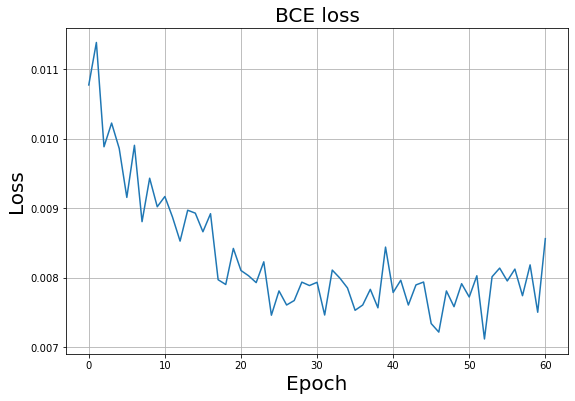

In [3]:
# Train the model
train_losses = fit_class(diabetes_model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
               verbose=0, early_stopping='dev', return_losses=True)

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("BCE loss", fontsize=20)
plt.show()

### Accuracy on test

In [4]:
test_class(diabetes_model, loss_function, test_loader)

Accuracy: 107/123 = 86.99186706542969%


### Accuracy on OOD

In [5]:
test_class(diabetes_model, loss_function, OOD_loader)

Accuracy: 49/154 = 31.81818199157715%


### 10-fold CV 

In [6]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):

    # Tensor datasets and data loaders on gpu
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test)
    train_loader = data_loaders.create_loader(train_dataset, batch_size_train, 'cuda')
    test_loader = data_loaders.create_loader(test_dataset, batch_size_test, 'cuda')

    # Model setup
    diabetes_model = model.diabetes_laplace(n_features, n_hidden_1, n_hidden_2).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(diabetes_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss, train_acc = fit_class(diabetes_model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
                           verbose=0, early_stopping=False, return_loss=True, return_acc=True) 
    test_loss, test_acc = test_class(diabetes_model, loss_function, test_loader, verbose=0, 
                                     return_loss=True, return_acc=True) 
    
    if verbose:
        print(f"Total train loss for this fold: {train_loss[-1] : .6f}")
        print(f"Average Train Cross-Entropy Loss: {train_loss[-1] / len(X_train) : .10f}")
        print(f"Total test loss for this fold: {test_loss : .6f}")
        print(f"Average Test Cross-Entropy Loss : {test_loss / len(X_test) : .10f}" )

    return train_acc, test_acc                # train acc is a list, test acc is a float

def k_fold_cv():
    n_splits = 10
    kf = KFold(n_splits)

    train_accs = np.zeros(n_splits)
    test_accs = np.zeros(n_splits)
    train_accs_plot = []                           # for plotting loss curves
    for i, (train_index, test_index) in enumerate(kf.split(X)):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print("\nTraining on fold no. %d" %(i+1))
        epoch_wise_train_accs, test_accs[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
        train_accs[i] = epoch_wise_train_accs[-1]
        train_accs_plot.append(epoch_wise_train_accs)

    print("Train accuracies:", train_accs)
    print("Test accuracies:", test_accs)

    avg_train_acc_k_folds = train_accs.mean()
    avg_test_acc_k_folds = test_accs.mean()
    print(f"\nAvg train accuracy over all folds: {avg_train_acc_k_folds :.5f}")
    print(f"Avg test accuracy over all folds: {avg_test_acc_k_folds :.5f}")

    plt.figure(figsize=(9,6))
    for accs in train_accs_plot:
        accs = [acc.cpu().detach().numpy() for acc in accs]
        plt.plot(accs)
    plt.grid()
    plt.xlabel("Epoch", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)
    plt.title("Train accuracy curves for 10 folds", fontsize=20)
    plt.show()

## Laplace approximation of the full network with full Hessian computation

In [7]:
LA = laplace_model(diabetes_model, 'classification', subset_of_weights='all', hessian_structure='kron')
LA.fit(train_loader)
LA.optimize_prior_precision(method='marglik')

In [8]:
#Predict 
posterior_samples = 1000

train_evaluation = evaluate.evaluate_class(
    model=LA, 
    loader=train_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Train data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

test_evaluation = evaluate.evaluate_class(
    model=LA, 
    loader=test_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Test data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

OOD_evaluation = evaluate.evaluate_class(
    model=LA, 
    loader=OOD_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, OOD data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: Laplace approximation full network
Evaluated on: Diabetes, Train data
Neural network: [100, 30]
Number of posterior samples: 1000
Average NLPD: -0.6592974663
SD of NLPD: 0.0167226333
Total NLPD: -323.7150559533
Average accuracy: 0.8044806719
Average AUROC: 0.8072268963
Average ECE: 0.0998464674

Test evaluation:
Inference type: Laplace approximation full network
Evaluated on: Diabetes, Test data
Neural network: [100, 30]
Number of posterior samples: 1000
Average NLPD: -0.6831046343
SD of NLPD: 0.009028672
Total NLPD: -84.0218700189
Average accuracy: 0.869918704
Average AUROC: 0.8627239466
Average ECE: 0.14106372

OOD evaluation:
Inference type: Laplace approximation full network
Evaluated on: Diabetes, OOD data
Neural network: [100, 30]
Number of posterior samples: 1000
Average NLPD: -0.4467476904
SD of NLPD: 0.0522887318
Total NLPD: -68.7991443216
Average accuracy: 0.3181818128
Average AUROC: 0.7456071377
Average ECE: 0.3780976534


## Last Layer Laplace Approximation with Kronecker factored log likelihood Hessian approximation

In [ ]:
diabetes_model = copy.deepcopy(diabetes_model_NN)

In [14]:
llla = Laplace(diabetes_model, 'classification')
llla.fit(train_loader)
llla.optimize_prior_precision(method='marglik')

In [15]:
#Predict 
posterior_samples = 10000

train_evaluation = evaluate.evaluate_class(
    model=llla, 
    loader=train_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Train data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

test_evaluation = evaluate.evaluate_class(
    model=llla, 
    loader=test_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Test data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

OOD_evaluation = evaluate.evaluate_class(
    model=llla, 
    loader=OOD_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, OOD data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: Last Layer Laplace Approximation
Evaluated on: Diabetes, Train data
Number of posterior samples: 1000
Average NLPD: -0.6881780624
Average accuracy: 0.8492871523
Average AUROC: 0.9267532825
Average ECE: 0.130605787

Test evaluation:
Inference type: Last Layer Laplace Approximation
Evaluated on: Diabetes, Test data
Number of posterior samples: 1000
Average NLPD: -0.6342914104
Average accuracy: 0.7804877758
Average AUROC: 0.7989520431
Average ECE: 0.1179951057

OOD evaluation:
Inference type: Last Layer Laplace Approximation
Evaluated on: Diabetes, OOD data
Number of posterior samples: 1000
Average NLPD: -0.5636971593
Average accuracy: 0.5909090638
Average AUROC: 1.0
Average ECE: 0.1479392648


C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


### Jointly optimize MAP and hyperparameters using online empirical Bayes

The method optimizes the neural network and the hyperparameters in an interleaved way and returns an optimally regularized LA.

In [16]:
diabetes_model_online = model.diabetes_laplace(n_features, n_hidden_1, n_hidden_2).to(device)

In [17]:
la, model, margliks, losses = marglik_training(
    model=diabetes_model_online, train_loader=train_loader, likelihood='classification',
    hessian_structure='full', backend=BackPackGGN, n_epochs=1000, 
    optimizer_kwargs={'lr': 1e-4}, prior_structure='scalar'
)

C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'src.model.diabetes_laplace'> although the module has parameters
  warnings.warn(


In [22]:
#Predict 
posterior_samples = 10000

train_evaluation = evaluate.evaluate_class(
    model=la, 
    loader=train_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Train data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

test_evaluation = evaluate.evaluate_class(
    model=la, 
    loader=test_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Test data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

OOD_evaluation = evaluate.evaluate_class(
    model=la, 
    loader=OOD_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, OOD data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)

C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'src.model.diabetes_laplace'> although the module has parameters
  warnings.warn(


Train evaluation:
Inference type: Laplace Approximation, All network parameters
Evaluated on: Diabetes, Train data
Number of posterior samples: 1000
Average NLPD: -0.5188138485
Average accuracy: 0.6863543987
Average AUROC: 0.7835415602
Average ECE: 0.1534085423

Test evaluation:
Inference type: Laplace Approximation, All network parameters
Evaluated on: Diabetes, Test data
Number of posterior samples: 1000
Average NLPD: -0.5144145489
Average accuracy: 0.6747967601
Average AUROC: 0.6977385283
Average ECE: 0.1478066295

OOD evaluation:
Inference type: Laplace Approximation, All network parameters
Evaluated on: Diabetes, OOD data
Number of posterior samples: 1000
Average NLPD: -0.5452381968
Average accuracy: 0.9480519295
Average AUROC: 0.9869281054
Average ECE: 0.3999116421


C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'src.model.diabetes_laplace'> although the module has parameters
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'src.model.diabetes_laplace'> although the module has parameters
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be